
1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para ATVI.



1 Failed download:
['DISH-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')

1 Failed download:
['MFGP-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para DISH-OLD.
No se encontraron datos para MFGP-OLD.



1 Failed download:
['VMW-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para VMW-OLD.



1 Failed download:
['CXO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para CXO.



1 Failed download:
['STOR-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para STOR-OLD.



1 Failed download:
['SCTL-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para SCTL-OLD.



1 Failed download:
['DOC-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para DOC-OLD.



1 Failed download:
['DCT-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para DCT-OLD.



1 Failed download:
['PCTI-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para PCTI-OLD.



1 Failed download:
['CPE-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para CPE-OLD.



1 Failed download:
['ESTE-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para ESTE-OLD.



1 Failed download:
['NXGN-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para NXGN-OLD.



1 Failed download:
['EVBG-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para EVBG-OLD.



1 Failed download:
['SLCA-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para SLCA-OLD.
$LEN.B: possibly delisted; No price data found  (1d 2021-01-01 -> 2024-08-10)


1 Failed download:
['LEN.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-01 -> 2024-08-10)')



No se encontraron datos para LEN.B.



1 Failed download:
['CIR-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para CIR-OLD.



1 Failed download:
['PGTI-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para PGTI-OLD.



1 Failed download:
['HCCI-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para HCCI-OLD.



1 Failed download:
['DOOR-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para DOOR-OLD.



1 Failed download:
['OXY.WS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para OXY.WS.



1 Failed download:
['MDC-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para MDC-OLD.



1 Failed download:
['SNPO-OLD']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para SNPO-OLD.



1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para BRK.B.



1 Failed download:
['BRK.A']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No se encontraron datos para BRK.A.


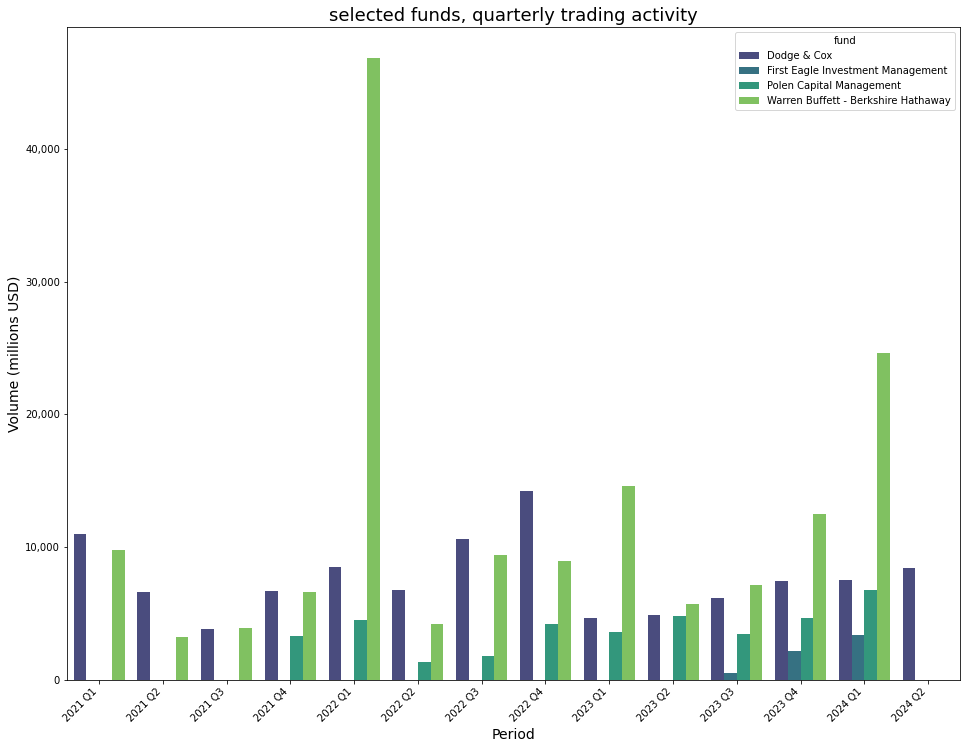

In [2]:
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def read_db_credentials(file_path):
    credentials = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            credentials[key] = value
    return credentials

file_path = 'DB_connection.txt'
credentials = read_db_credentials(file_path)
connection_string = f"postgresql+psycopg2://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database']}"
engine = create_engine(connection_string)

top_funds = ['BRK','DODGX','pcm','FE']

funds_str = "', '".join(top_funds)

query = f"""
SELECT symbol, share_change, transaction_type, quarter, year, fund
FROM Activity as act
JOIN superinvestors as sup ON act.fund_code = sup.id
WHERE (year = '2021' OR year = '2022' OR year = '2023' OR year = '2024') 
AND act.fund_code IN ('{funds_str}')
ORDER BY share_change DESC
"""

df_activity = pd.read_sql(query, engine)
symbols = df_activity['symbol'].unique()
start_date = '2021-01-01'
df_prices_list = []

for symbol in symbols:
    try:
        stock_data = yf.download(symbol, start=start_date, progress=False)
        if stock_data.empty:
            print(f"No se encontraron datos para {symbol}.")
            continue
        stock_data['Symbol'] = symbol
        stock_data.reset_index(inplace=True)
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data['year'] = stock_data['Date'].dt.year.astype(str)
        stock_data['quarter'] = stock_data['Date'].dt.quarter.astype(str)
        stock_data_filtered = stock_data[['Symbol', 'quarter', 'year', 'Adj Close']]
        stock_data_filtered.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
        df_prices_list.append(stock_data_filtered)
    except Exception as e:
        print(f"Error al descargar datos para {symbol}: {e}")

df_prices = pd.concat(df_prices_list)

df_last_prices = df_prices.groupby(['Symbol', 'year', 'quarter']).last().reset_index()
df_activity_with_prices = pd.merge(df_activity, df_last_prices, left_on=['symbol', 'year', 'quarter'], right_on=['Symbol', 'year', 'quarter'], how='left')
df_activity_with_prices = df_activity_with_prices.drop_duplicates()
df_activity_with_prices.dropna(subset=['adj_close'], inplace=True)
df_activity_with_prices['value'] = df_activity_with_prices['share_change'] * df_activity_with_prices['adj_close']


df_grouped = df_activity_with_prices.groupby(['symbol', 'year', 'quarter', 'fund']).agg(
    total_shares=pd.NamedAgg(column='share_change', aggfunc='sum'),
    total_value=pd.NamedAgg(column='value', aggfunc=lambda x: x.sum() / 1_000_000),  
    transaction_type=pd.NamedAgg(column='transaction_type', aggfunc=lambda x: 'combined' if len(x) > 1 else x.iloc[0])
).reset_index()

df_grouped['total_value'] = df_grouped['total_value'].round(2)  

df_funds_period_grouped = df_grouped.groupby(['fund', 'year', 'quarter']).agg(
    total_value=pd.NamedAgg(column='total_value', aggfunc='sum')
).reset_index()

df_funds_period_grouped['period'] = df_funds_period_grouped['year'] + ' Q' + df_funds_period_grouped['quarter']
df_funds_period_grouped_sorted = df_funds_period_grouped.sort_values(by=['fund', 'year', 'quarter'])


plt.figure(figsize=(16, 12))
sns.barplot(x='period', y='total_value', hue='fund', data=df_funds_period_grouped_sorted, palette='viridis')

plt.title('selected funds, quarterly trading activity', fontsize=18)
plt.xlabel('Period', fontsize=14)
plt.ylabel('Volume (millions USD)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('Trading activity by fund.jpg')
plt.show()
